### Tactical Role Clustering of Defenders Using Kernel PCA and Gaussian Mixture Models


📈 Silhouette Score: 0.1615


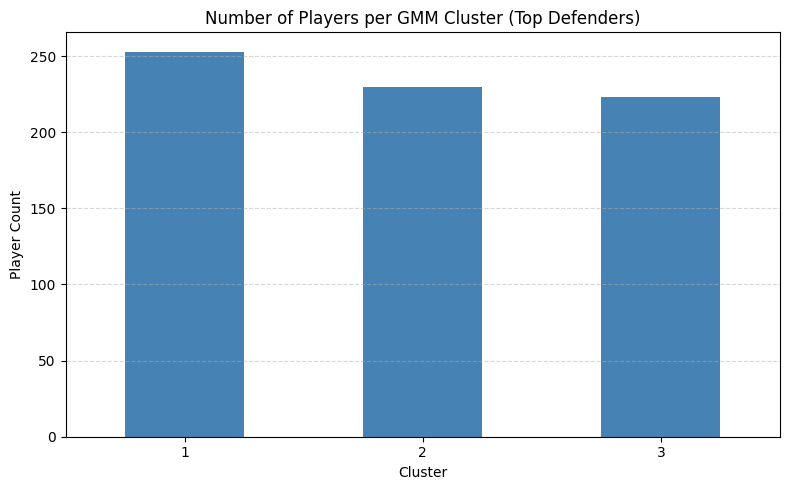

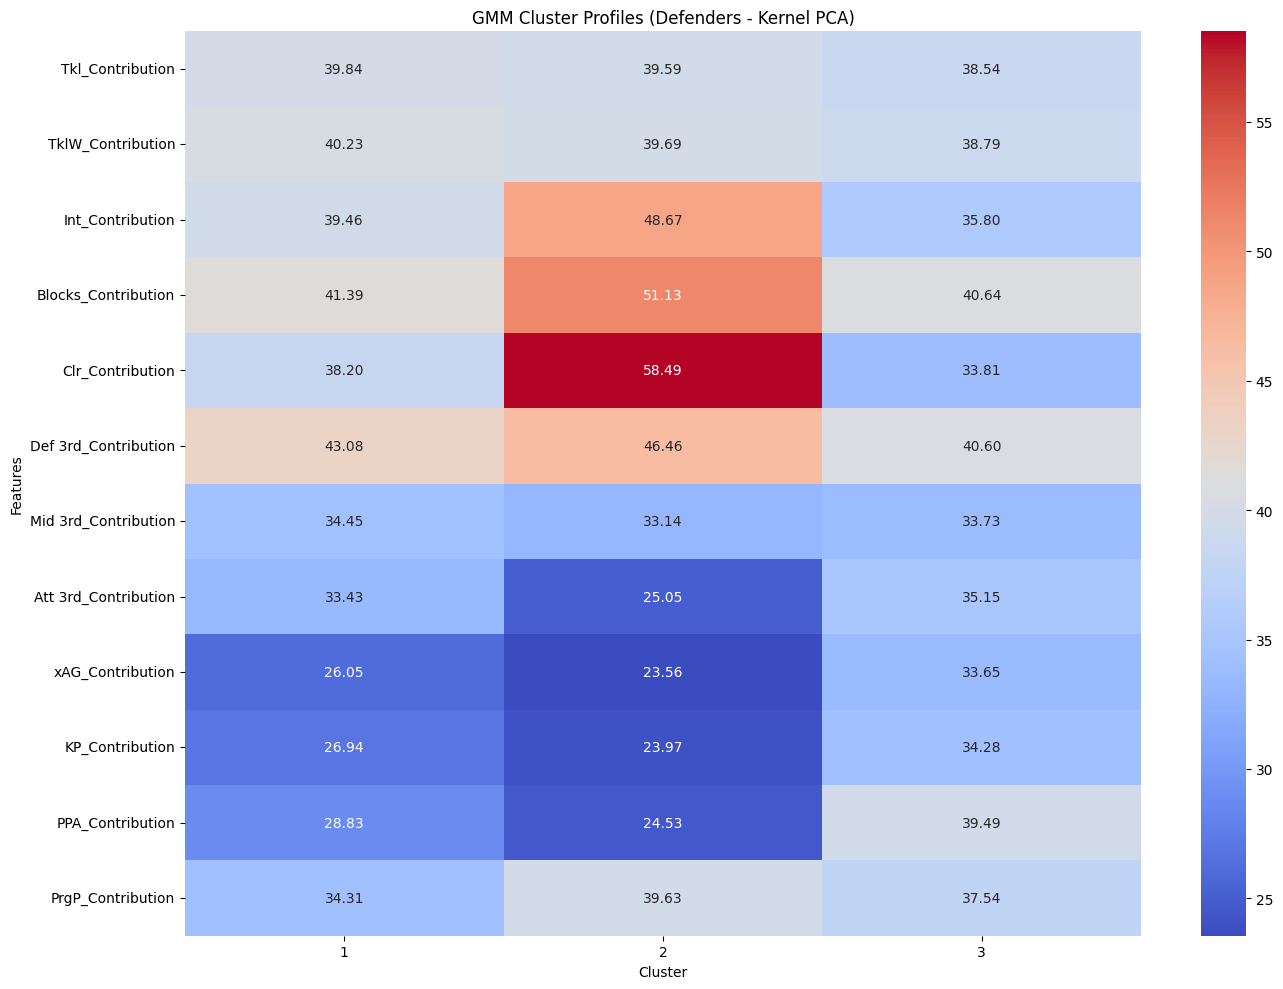

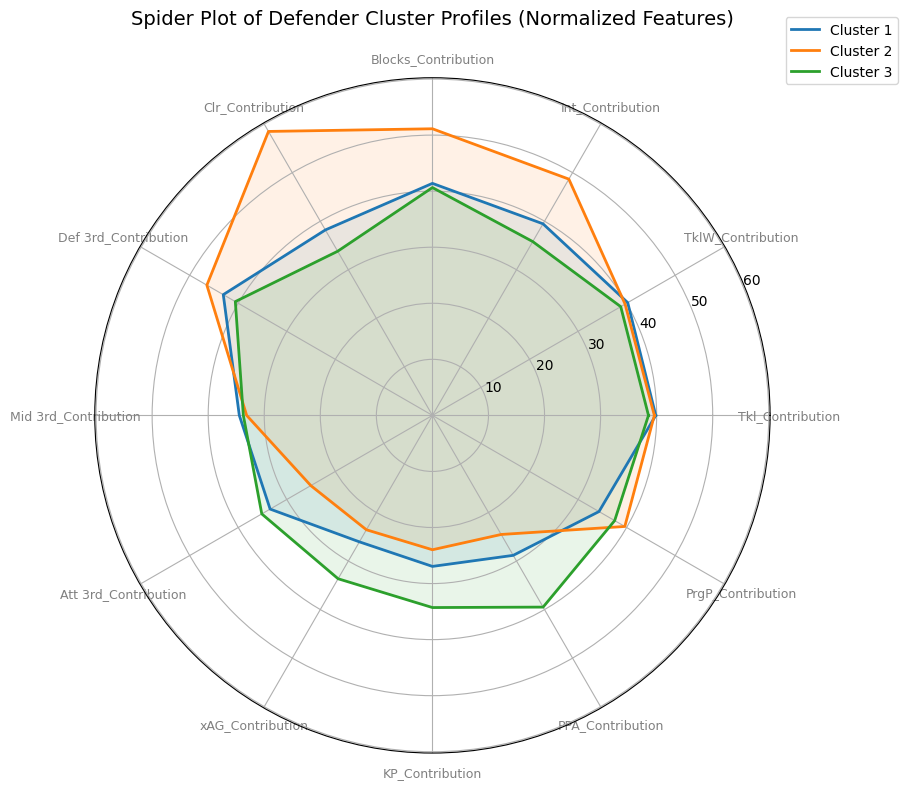

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from math import pi

# === Load and preprocess data ===
players_df = pd.read_csv("players_2023_2024.csv")
players_df.columns = players_df.columns.str.strip()

# === Filter defenders only ===
players_df["Has_DF"] = players_df["Pos"].apply(lambda pos: "DF" in str(pos).split(","))
df_df_all = players_df[players_df["Has_DF"]].drop_duplicates(subset=["Player"]).copy()

# === Define defender features
contribution_features = [
    "Tkl_Contribution", "TklW_Contribution", "Int_Contribution",
    "Blocks_Contribution", "Clr_Contribution", "Def 3rd_Contribution",
    "Mid 3rd_Contribution", "Att 3rd_Contribution",
    "xAG_Contribution", "KP_Contribution", "PPA_Contribution", "PrgP_Contribution"
]

# === Clean & normalize ALL defenders
X_all = df_df_all[contribution_features].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
X_all_profile = X_all.div(X_all.sum(axis=1).replace(0, 1), axis=0)

# === Filter only high-contribution defenders for clustering
min_total_contribution = 300.0
X_cluster = X_all[X_all.sum(axis=1) >= min_total_contribution]
X_cluster_profile = X_cluster.div(X_cluster.sum(axis=1), axis=0)
df_cluster = df_df_all.loc[X_cluster.index].copy()

# === Kernel PCA on clustered players only
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=1.0, random_state=42)
X_kpca = kpca.fit_transform(X_cluster_profile)

# === GMM clustering
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_cluster["Cluster"] = gmm.fit_predict(X_kpca) + 1

# === Evaluate clustering quality
sil_score = silhouette_score(X_kpca, df_cluster["Cluster"])
print(f"📈 Silhouette Score: {sil_score:.4f}")

# === Plot cluster distribution
plt.figure(figsize=(8, 5))
df_cluster["Cluster"].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Number of Players per GMM Cluster (Top Defenders)")
plt.xlabel("Cluster")
plt.ylabel("Player Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# === Heatmap of cluster mean profiles
cluster_summary = df_cluster.groupby("Cluster")[contribution_features].mean().round(2)
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_summary.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("GMM Cluster Profiles (Defenders - Kernel PCA)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# === Radar chart of clusters
def plot_spider_chart(cluster_summary):
    features = cluster_summary.columns.tolist()
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], features, color='grey', size=9)
    colors = sns.color_palette("tab10", n_colors=len(cluster_summary))

    for i, (idx, row) in enumerate(cluster_summary.iterrows()):
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f"Cluster {idx}", color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Spider Plot of Defender Cluster Profiles (Normalized Features)", size=14, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

plot_spider_chart(cluster_summary)

# === Save cluster profiles (role vectors)
role_vectors_df = cluster_summary.copy()
role_vectors_df.index = ["DF_" + str(i) for i in role_vectors_df.index]
role_vectors_df.to_csv("role_vectors_def.csv")

# === Assign Role_Label to ALL defenders using cosine similarity
cluster_vectors = role_vectors_df.values
similarity_matrix = cosine_similarity(X_all_profile.values, cluster_vectors)
best_match_index = similarity_matrix.argmax(axis=1)

df_df_all = df_df_all.loc[X_all.index].copy()  # sync with valid (non-NaN) defenders
df_df_all["Role_Label"] = ["DF_" + str(i + 1) for i in best_match_index]
df_df_all["Role_Similarity"] = similarity_matrix.max(axis=1)

# === Optional: Add human-readable names
role_name_map = {
    "DF_1": "Traditional Balanced Defender",
    "DF_2": "Ball Winning Defender",
    "DF_3": "Progressive Defender",
}
df_df_all["Role_Name"] = df_df_all["Role_Label"].map(role_name_map)

# === Save full player-role mapping (all defenders)
df_df_all.to_csv("players_with_roles_def.csv", index=False)


### Tactical Role Clustering of Midfielders Using Kernel PCA and Gaussian Mixture Models


📈 Midfielder Silhouette Score: 0.2127


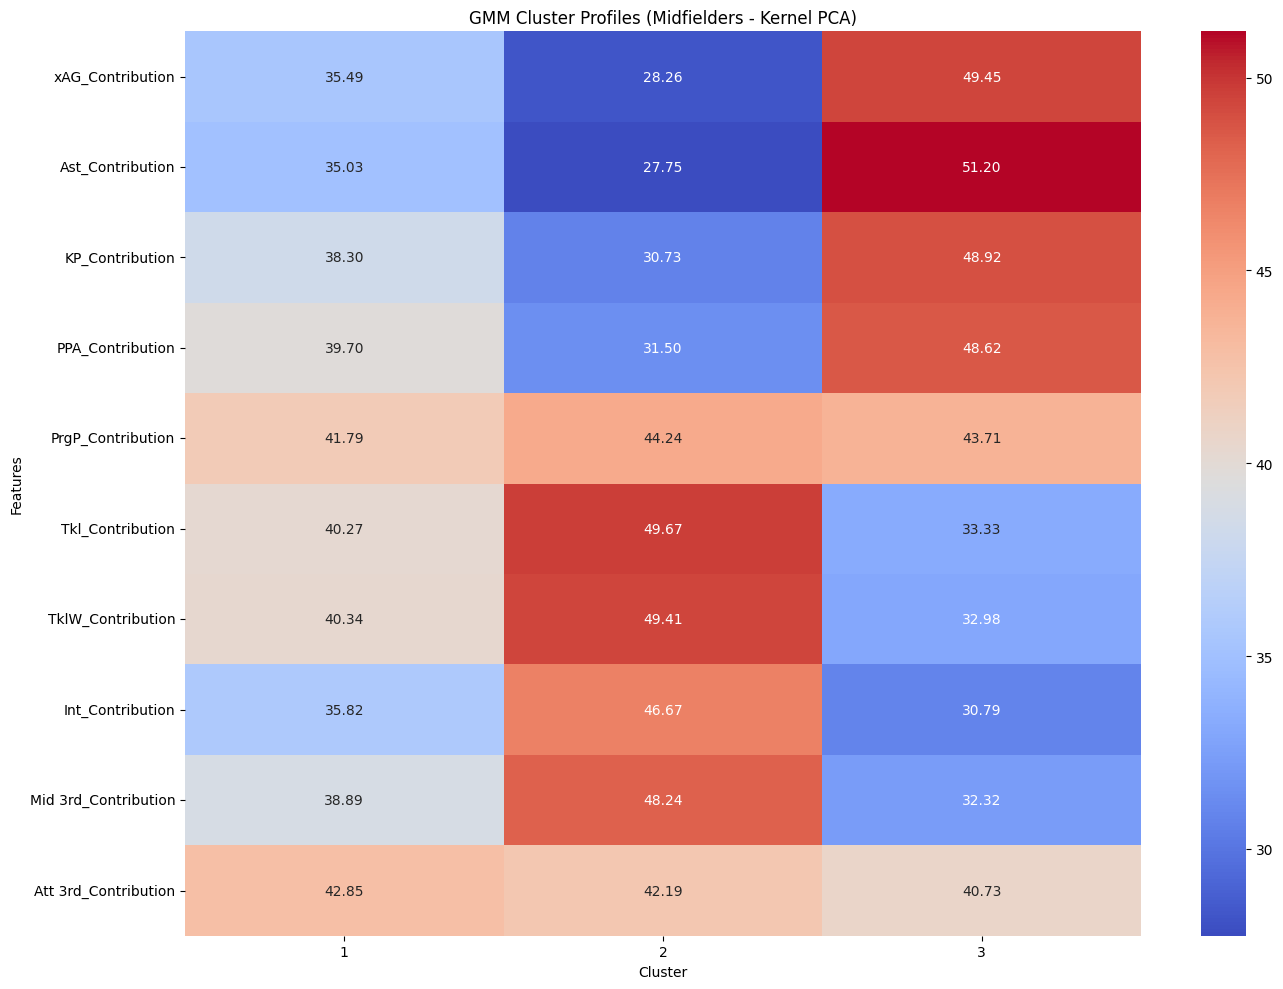

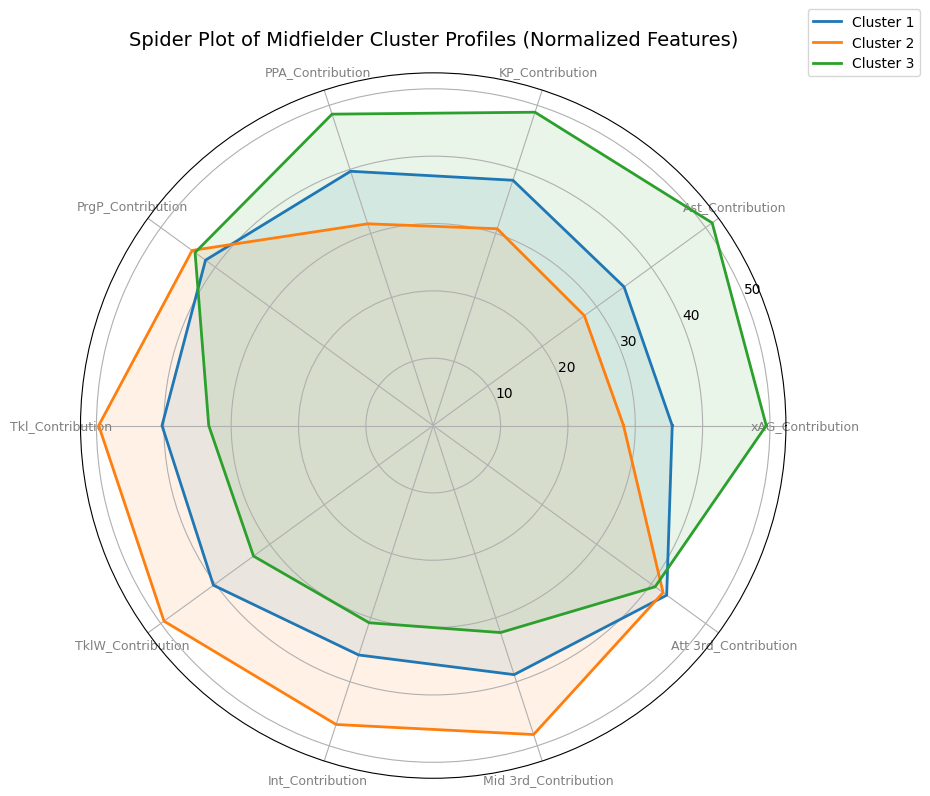

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from math import pi

# === Load and preprocess data ===
players_df = pd.read_csv("players_2023_2024.csv")
players_df.columns = players_df.columns.str.strip()

# === Filter midfielders only ===
players_df["Has_MF"] = players_df["Pos"].apply(lambda pos: "MF" in str(pos).split(","))
df_mf_all = players_df[players_df["Has_MF"]].drop_duplicates(subset=["Player"]).copy()

# === Define midfielder contribution features
mid_contribution_features = [
    "xAG_Contribution", "Ast_Contribution", "KP_Contribution",
    "PPA_Contribution", "PrgP_Contribution",
    "Tkl_Contribution", "TklW_Contribution", "Int_Contribution",
    "Mid 3rd_Contribution", "Att 3rd_Contribution"
]

# === Clean and normalize ALL midfielders
X_all = df_mf_all[mid_contribution_features].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
X_all_profile = X_all.div(X_all.sum(axis=1).replace(0, 1), axis=0)

# === Filter only strong midfielders for clustering
min_total_contribution = 300
X_cluster = X_all[X_all.sum(axis=1) >= min_total_contribution]
X_cluster_profile = X_cluster.div(X_cluster.sum(axis=1), axis=0)
df_cluster = df_mf_all.loc[X_cluster.index].copy()

# === Kernel PCA on clustered players only
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=1.0, random_state=42)
X_kpca = kpca.fit_transform(X_cluster_profile)

# === GMM clustering
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_cluster["Cluster"] = gmm.fit_predict(X_kpca) + 1

# === Silhouette score
sil_score = silhouette_score(X_kpca, df_cluster["Cluster"])
print(f"📈 Midfielder Silhouette Score: {sil_score:.4f}")

# === Heatmap: cluster profiles
cluster_summary = df_cluster.groupby("Cluster")[mid_contribution_features].mean().round(2)
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_summary.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("GMM Cluster Profiles (Midfielders - Kernel PCA)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# === Radar chart
def plot_spider_chart(cluster_summary):
    features = cluster_summary.columns.tolist()
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], features, color='grey', size=9)
    colors = sns.color_palette("tab10", n_colors=len(cluster_summary))

    for i, (idx, row) in enumerate(cluster_summary.iterrows()):
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f"Cluster {idx}", color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Spider Plot of Midfielder Cluster Profiles (Normalized Features)", size=14, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

plot_spider_chart(cluster_summary)

# === Save cluster profiles (role vectors)
role_vectors_df = cluster_summary.copy()
role_vectors_df.index = ["MF_" + str(i) for i in role_vectors_df.index]
role_vectors_df.to_csv("role_vectors_mf.csv")

# === Assign Role_Label to ALL midfielders using cosine similarity
cluster_vectors = role_vectors_df.values
similarity_matrix = cosine_similarity(X_all_profile.values, cluster_vectors)
best_match_index = similarity_matrix.argmax(axis=1)

df_mf_all = df_mf_all.loc[X_all.index].copy()  # sync with valid inputs
df_mf_all["Role_Label"] = ["MF_" + str(i + 1) for i in best_match_index]
df_mf_all["Role_Similarity"] = similarity_matrix.max(axis=1)

# === OPTIONAL: Add human-readable Role Names
role_name_map = {
    "MF_1": "Box-to-Box Midfielder",
    "MF_2": "Defensive Midfielder",
    "MF_3": "Playmaker Midfielder",
}
df_mf_all["Role_Name"] = df_mf_all["Role_Label"].map(role_name_map)

# === Append to combined file
df_def = pd.read_csv("players_with_roles_def.csv")
all_players = pd.concat([df_def, df_mf_all], ignore_index=True)
all_players.to_csv("players_with_roles_all.csv", index=False)


### Tactical Role Clustering of Forwards Using Finishing and xG-Based Contributions


📈 Forward Silhouette Score: 0.1053


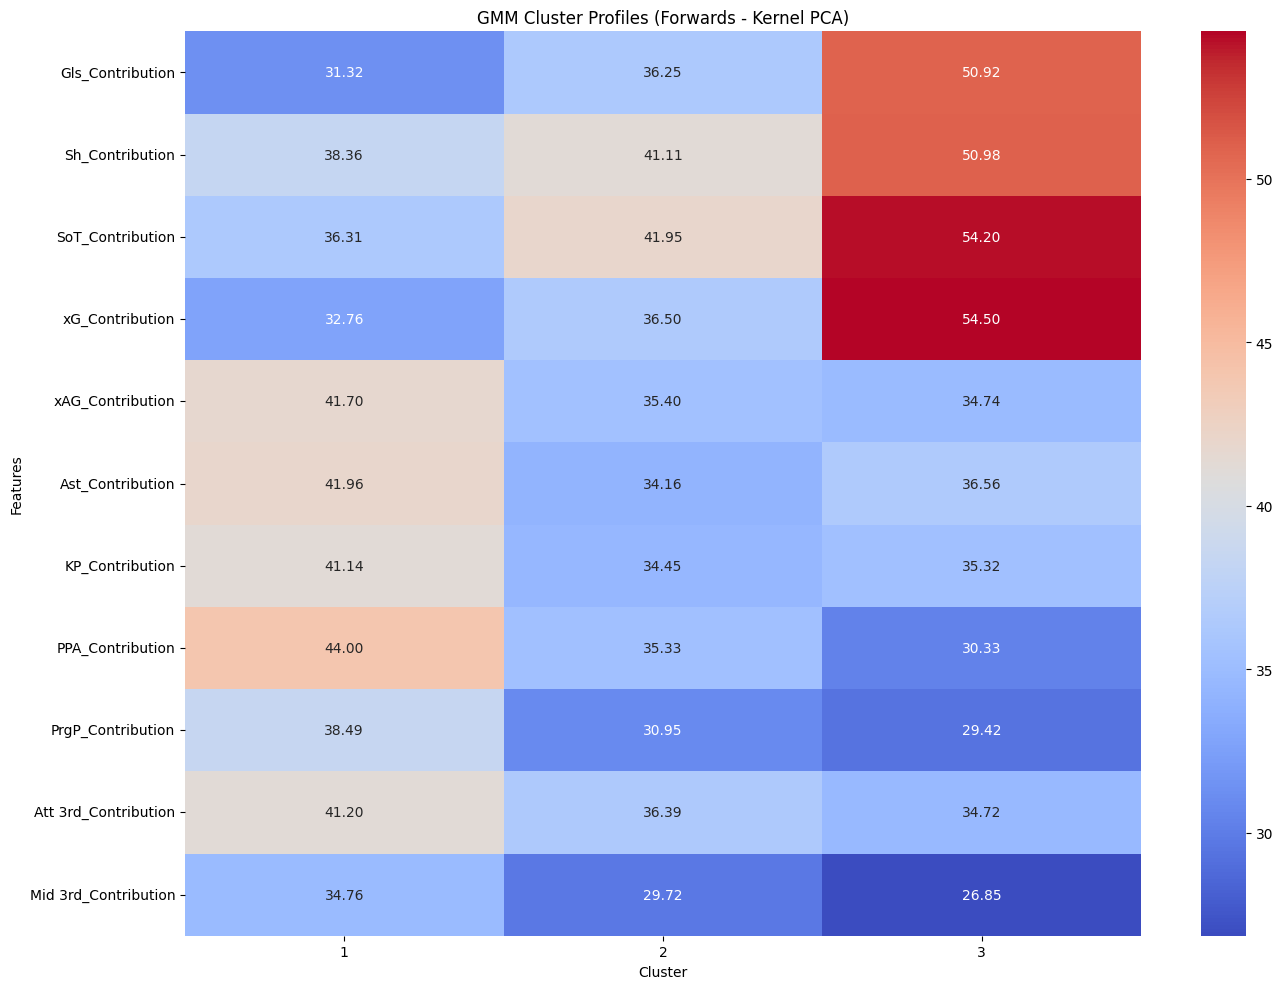

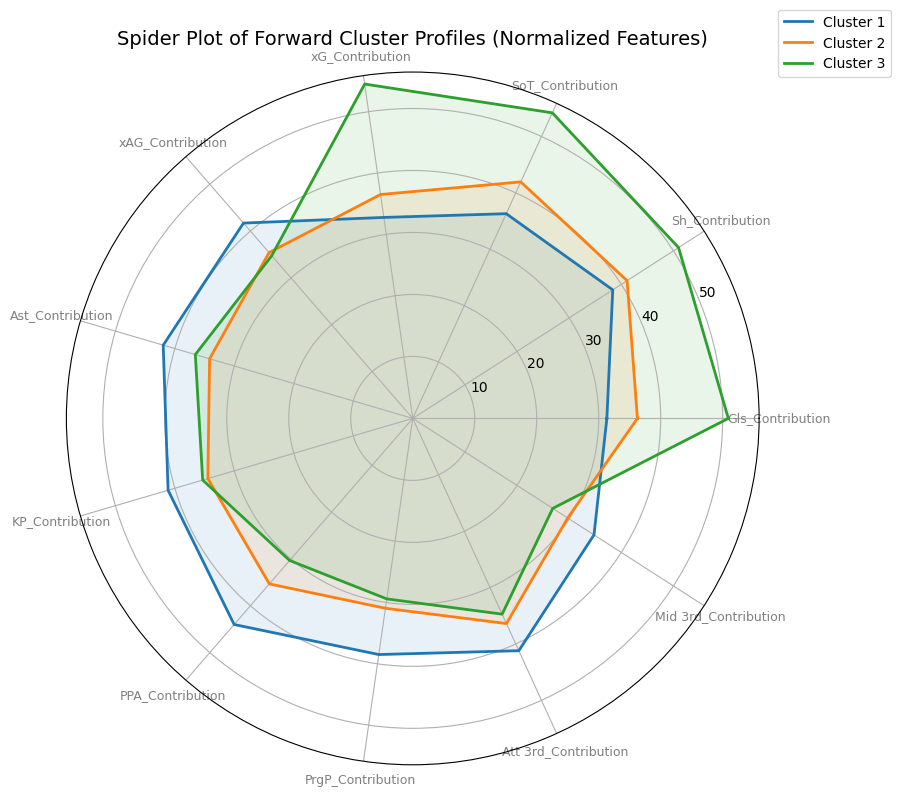

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from math import pi

# === Load and preprocess data ===
players_df = pd.read_csv("players_2023_2024.csv")
players_df.columns = players_df.columns.str.strip()

# === Filter forwards only ===
players_df["Has_FW"] = players_df["Pos"].apply(lambda pos: "FW" in str(pos).split(","))
df_fw_all = players_df[players_df["Has_FW"]].drop_duplicates(subset=["Player"]).copy()

# === Define forward contribution features ===
fw_contribution_features = [
    "Gls_Contribution", "Sh_Contribution", "SoT_Contribution",
    "xG_Contribution", "xAG_Contribution", "Ast_Contribution",
    "KP_Contribution", "PPA_Contribution", "PrgP_Contribution",
    "Att 3rd_Contribution", "Mid 3rd_Contribution"
]

# === Clean and normalize ALL forwards
X_all = df_fw_all[fw_contribution_features].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
X_all_profile = X_all.div(X_all.sum(axis=1).replace(0, 1), axis=0)

# === Filter high-contribution forwards for clustering
min_total_contribution = 300
X_cluster = X_all[X_all.sum(axis=1) >= min_total_contribution]
X_cluster_profile = X_cluster.div(X_cluster.sum(axis=1), axis=0)
df_cluster = df_fw_all.loc[X_cluster.index].copy()

# === Kernel PCA
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=1.0, random_state=42)
X_kpca = kpca.fit_transform(X_cluster_profile)

# === GMM clustering
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_cluster["Cluster"] = gmm.fit_predict(X_kpca) + 1

# === Silhouette Score
silhouette = silhouette_score(X_kpca, df_cluster["Cluster"])
print(f"📈 Forward Silhouette Score: {silhouette:.4f}")

# === Heatmap of cluster profiles
cluster_summary = df_cluster.groupby("Cluster")[fw_contribution_features].mean().round(2)
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_summary.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("GMM Cluster Profiles (Forwards - Kernel PCA)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# === Radar chart
def plot_spider_chart(cluster_summary):
    features = cluster_summary.columns.tolist()
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], features, color='grey', size=9)
    colors = sns.color_palette("tab10", n_colors=len(cluster_summary))

    for i, (idx, row) in enumerate(cluster_summary.iterrows()):
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f"Cluster {idx}", color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Spider Plot of Forward Cluster Profiles (Normalized Features)", size=14, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

plot_spider_chart(cluster_summary)

# === Save cluster centroids as role vectors
role_vectors_df = cluster_summary.copy()
role_vectors_df.index = ["FW_" + str(i) for i in role_vectors_df.index]
role_vectors_df.to_csv("role_vectors_fw.csv")

# === Classify ALL forwards using cosine similarity
cluster_vectors = role_vectors_df.values
similarity_matrix = cosine_similarity(X_all_profile.values, cluster_vectors)
best_match_index = similarity_matrix.argmax(axis=1)

df_fw_all = df_fw_all.loc[X_all.index].copy()
df_fw_all["Role_Label"] = ["FW_" + str(i + 1) for i in best_match_index]
df_fw_all["Role_Similarity"] = similarity_matrix.max(axis=1)

# === Optional role naming
role_name_map = {
    "FW_1": "Creative - High Pressure Forward",
    "FW_2": "Traditional Forward",
    "FW_3": "Scoring Forward"
}
df_fw_all["Role_Name"] = df_fw_all["Role_Label"].map(role_name_map)

# === Append to unified player-role dataset
df_all = pd.read_csv("players_with_roles_all.csv")
df_all = pd.concat([df_all, df_fw_all], ignore_index=True)
df_all.to_csv("players_with_roles_all.csv", index=False)


In [ ]:
# === Load merged file with all classified players
df_all = pd.read_csv("players_with_roles_all.csv")

# === Define which features belong to which line
def_features = [
    "Tkl_Contribution", "TklW_Contribution", "Int_Contribution",
    "Blocks_Contribution", "Clr_Contribution", "Def 3rd_Contribution",
    "Mid 3rd_Contribution", "Att 3rd_Contribution"
]
mid_features = [
    "xAG_Contribution", "Ast_Contribution", "KP_Contribution",
    "PPA_Contribution", "PrgP_Contribution",
    "Tkl_Contribution", "TklW_Contribution", "Int_Contribution",
    "Mid 3rd_Contribution", "Att 3rd_Contribution"
]
att_features = [
    "Gls_Contribution", "Sh_Contribution", "SoT_Contribution",
    "xG_Contribution", "xAG_Contribution", "Ast_Contribution",
    "KP_Contribution", "PPA_Contribution", "PrgP_Contribution",
    "Att 3rd_Contribution", "Mid 3rd_Contribution"
]

# === Compute total contribution per line
df_all["Total_DEF"] = df_all[def_features].sum(axis=1, skipna=True)
df_all["Total_MID"] = df_all[mid_features].sum(axis=1, skipna=True)
df_all["Total_ATT"] = df_all[att_features].sum(axis=1, skipna=True)

# === Assign dominant line based on highest contribution
def dominant_role(row):
    vals = {"DF": row["Total_Player_Contribution_def"], "MF": row["Total_Player_Contribution_mid"], "FW": row["Total_Player_Contribution_att"]}
    return max(vals, key=vals.get)

df_all["PrimaryLine"] = df_all.apply(dominant_role, axis=1)

# === Set position role priority: DF > MF > FW (fallback rule in tie cases)
priority = {"DF": 0, "MF": 1, "FW": 2}
df_all["LinePriority"] = df_all["PrimaryLine"].map(priority)

# === Keep only best entry per player based on highest Role_Similarity (and then priority if tied)
df_all = df_all.sort_values(["Player", "Role_Similarity", "LinePriority"], ascending=[True, False, True])
df_all_unique = df_all.drop_duplicates(subset="Player", keep="first").copy()

# === Final save
df_all_unique.drop(columns=["Total_DEF", "Total_MID", "Total_ATT", "LinePriority","Has_MF","Has_FW","Has_DF","PrimaryLine"], inplace=True)
df_all_unique.to_csv("players_with_roles_all_unique.csv", index=False)

print(f"✅ Unique player-role file saved with {len(df_all_unique)} players.")


✅ Unique player-role file saved with 2165 players.


### Role-Based Tactical Needs Ranking Using Cosine Similarity Between Team Deficiencies and Role Profiles


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def rank_team_role_needs(
    target_team: str,
    needs_file: str = "teams_needs_2023_2024.csv",
    roles_files: dict = None,
    needs_rename_map: dict = None,
    top_n: int = 10
) -> pd.DataFrame:
    if roles_files is None:
        roles_files = {
            "DEF": ("role_vectors_def.csv", [
                "Tkl_Contribution", "TklW_Contribution", "Int_Contribution", "Blocks_Contribution", "Clr_Contribution",
                "Def 3rd_Contribution", "Mid 3rd_Contribution", "Att 3rd_Contribution", "xAG_Contribution",
                "KP_Contribution", "PPA_Contribution", "PrgP_Contribution"
            ]),
            "MID": ("role_vectors_mf.csv", [
                "xAG_Contribution", "Ast_Contribution", "KP_Contribution", "PPA_Contribution", "PrgP_Contribution",
                "Tkl_Contribution", "TklW_Contribution", "Int_Contribution", "Mid 3rd_Contribution", "Att 3rd_Contribution"
            ]),
            "ATT": ("role_vectors_fw.csv", [
                "Gls_Contribution", "Sh_Contribution", "SoT_Contribution", "xG_Contribution", "xAG_Contribution",
                "Ast_Contribution", "KP_Contribution", "PPA_Contribution", "PrgP_Contribution",
                "Att 3rd_Contribution", "Mid 3rd_Contribution"
            ])
        }

    if needs_rename_map is None:
        needs_rename_map = {
            "standard_Gls": "Gls_Contribution", "shooting_Sh": "Sh_Contribution", "shooting_SoT": "SoT_Contribution",
            "shooting_xG": "xG_Contribution", "passing_xAG": "xAG_Contribution", "passing_Ast": "Ast_Contribution",
            "passing_KP": "KP_Contribution", "passing_PPA": "PPA_Contribution", "passing_PrgP": "PrgP_Contribution",
            "defense_Blocks": "Blocks_Contribution", "defense_TklW": "TklW_Contribution", "defense_Def 3rd": "Def 3rd_Contribution",
            "defense_Mid 3rd": "Mid 3rd_Contribution", "defense_Att 3rd": "Att 3rd_Contribution",
            "defense_Tkl": "Tkl_Contribution", "defense_Int": "Int_Contribution", "defense_Clr": "Clr_Contribution"
        }

    # Load and clean team needs
    team_needs_df = pd.read_csv(needs_file)
    team_needs_df.rename(columns=needs_rename_map, inplace=True)

    # Select team row
    team_row = team_needs_df[team_needs_df["Squad"] == target_team]
    if team_row.empty:
        raise ValueError(f"Team '{target_team}' not found in team needs file.")

    # Extract team total need weights
    total_needs = {
        "DEF": float(team_row["Team_Def_Score"].iloc[0]),
        "MID": float(team_row["Team_Mid_Score"].iloc[0]),
        "ATT": float(team_row["Team_Att_Score"].iloc[0])
    }

    # Process each role file
    all_results = []
    for position, (file, features) in roles_files.items():
        role_df = pd.read_csv(file)

        missing_feats = [f for f in features if f not in team_row.columns]
        if missing_feats:
            raise ValueError(f"Missing features in team needs for {position}: {missing_feats}")

        team_vector = team_row[features].values.reshape(1, -1)
        role_vectors = role_df[features].values

        cos_sims = cosine_similarity(team_vector, role_vectors)[0]
        weighted_sims = cos_sims * total_needs[position]

        result_df = role_df.copy()
        result_df["Cosine_Similarity"] = cos_sims
        result_df["Weighted_Similarity"] = weighted_sims
        result_df["Position"] = position

        all_results.append(result_df[["Role", "Position", "Cosine_Similarity", "Weighted_Similarity"]])

    # Combine and sort
    final_df = pd.concat(all_results, ignore_index=True)
    final_df_sorted = final_df.sort_values(by="Weighted_Similarity", ascending=False)

    return final_df_sorted.head(top_n)


In [ ]:
top_roles = rank_team_role_needs("Real Madrid")
print(top_roles)


                               Role Position  Cosine_Similarity  \
4              Defensive Midfielder      MID           0.977996   
3             Box-to-Box Midfielder      MID           0.958526   
5              Playmaker Midfielder      MID           0.896109   
6  Creative - High Pressure Forward      ATT           0.949608   
7               Traditional Forward      ATT           0.941731   
0     Traditional Balanced Defender      DEF           0.981932   
1             Ball Winning Defender      DEF           0.972108   
2              Progressive Defender      DEF           0.967189   
8                   Scoring Forward      ATT           0.897673   

   Weighted_Similarity  
4            41.035395  
3            40.218444  
5            37.599531  
6            35.532145  
7            35.237390  
0            34.966352  
1            34.616512  
2            34.441367  
8            33.588827  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_role_needs(role_df, team_name: str):
    # Define fixed colors for each position
    position_colors = {
        "DEF": "#1f77b4",  # blue
        "MID": "#2ca02c",  # green
        "ATT": "#ff7f0e"   # orange
    }

    # Set the color palette explicitly
    palette = role_df["Position"].map(position_colors)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=role_df,
        x="Weighted_Similarity",
        y="Role",
        hue="Position",
        dodge=False,
        palette=position_colors
    )
    plt.title(f"Top Role Needs for {team_name}")
    plt.xlabel("Weighted Similarity (Fit × Need)")
    plt.ylabel("Role")
    plt.legend(title="Position")
    plt.tight_layout()
    plt.show()


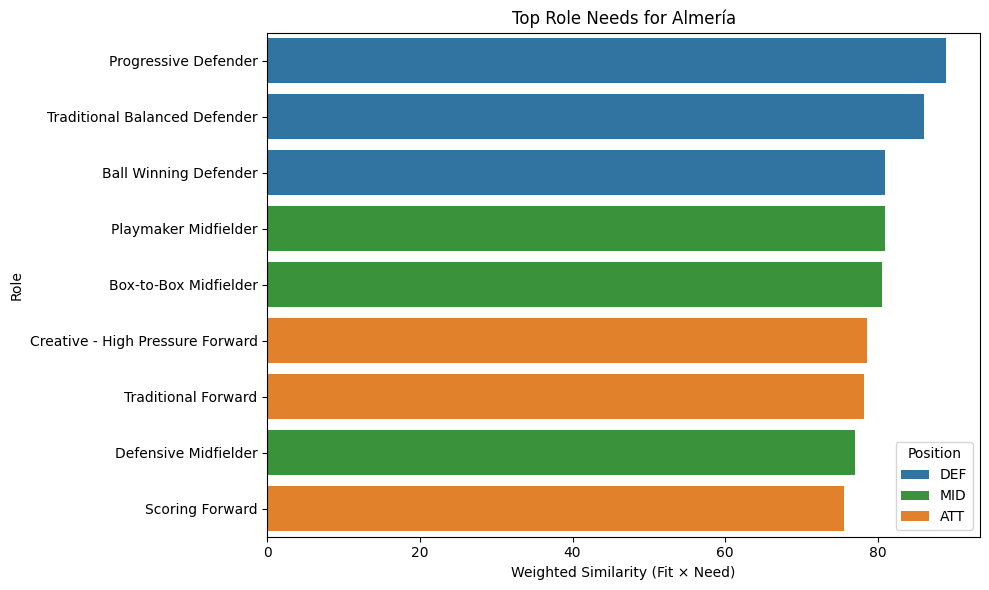

In [ ]:
# Step 1: Get top roles
top_roles = rank_team_role_needs("Almería", top_n=10)

# Step 2: Plot
plot_top_role_needs(top_roles, "Almería")
